In [1]:
import os
import pickle
from PIL import Image
import numpy as np
import glob
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.links.caffe import CaffeFunction
from matplotlib import pylab as plt

#  データセットを作る

In [2]:
from chainer.datasets import LabeledImageDataset
from itertools import chain
# 画像フォルダ
IMG_DIR = 'datas'
# 各注視点ごとのフォルダ
dnames = glob.glob('{}/*'.format(IMG_DIR))
# キャプチャのパス
fnames = [glob.glob('{}/*.jpg'.format(d)) for d in dnames
          if not os.path.exists('{}/ignore'.format(d))]
fnames = list(chain.from_iterable(fnames))

labels = [os.path.basename(os.path.dirname(fn)) for fn in fnames]
dnames = [os.path.basename(d) for d in dnames
          if not os.path.exists('{}/ignore'.format(d))]
labels = [dnames.index(l) for l in labels]

d = LabeledImageDataset(list(zip(fnames, labels)))

# 平均画像の作成

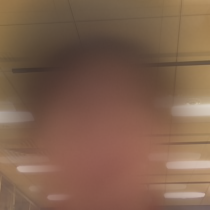

In [3]:
imgArray = None
for fname in fnames:
    im = Image.open(fname)
    if type(imgArray) == type(None):
        imgArray = np.asarray(im)/len(fnames)
    else:
        imgArray += np.asarray(im)/len(fnames)

pilImg = Image.fromarray(np.uint8(imgArray))
pilImg

# データセットを加工する

In [4]:
from chainer.datasets import TransformDataset
from PIL import Image

width, height = 224, 224

# 平均画像を用意する
imgArray = None
for fname in fnames:
    img = Image.open(fname)
    img = img.resize((width, height), Image.BICUBIC)
    im = np.asarray(img, dtype=np.float32).transpose(2, 0, 1)
    if type(imgArray) == type(None):
        imgArray = np.asarray(im)/len(fnames)
    else:
        imgArray += np.asarray(im)/len(fnames)
mean_image = imgArray.copy()

# 各データに行う変換
def transform(inputs):
    img, label = inputs
    img = img[:3, ...]
    img = img.astype(np.uint8)
    img = Image.fromarray(img.transpose(1, 2, 0))
    img = img.resize((width, height), Image.BICUBIC)
    img = np.asarray(img, dtype=np.float32).transpose(2, 0, 1)
    img = img - mean_image
    return img, label

# 変換付きデータセットにする
td = TransformDataset(d, transform)

In [5]:
from chainer import datasets

train_img, valid_img = datasets.split_dataset_random(td, int(len(d) * 0.8), seed=0)

# モデルの読み込み

In [6]:
%%time
MODEL = 'model/bvlc_googlenet.caffemodel'
PICKLE = 'model/ggnet.pkl'
if os.path.exists(PICKLE):
    print("Load pickle")
    with open(PICKLE, 'rb') as pkl:
        model = pickle.load(pkl)
else:
    print("Load caffemodel and make pickle")
    if os.path.exists(MODEL):
        model = CaffeFunction(MODEL)
        with open(PICKLE, 'wb') as pkl:
            pickle.dump(model, pkl)
    print(MODEL + " not found.")

Load caffemodel and make pickle
model/bvlc_googlenet.caffemodel not found.
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 357 µs


# GoogLeNetのモデル

In [7]:
class GoogLeNet(Chain):
    insize = 224
    
    def __init__(self):
        super(GoogLeNet, self).__init__()
        with self.init_scope():
            self.conv1 =  L.Convolution2D(3, 64, 7, stride=2, pad=3)
            self.conv2_reduce = L.Convolution2D(64, 64, 1)
            self.conv2 = L.Convolution2D(64, 192, 3, stride=1, pad=1)
            self.inception_3a = L.Inception(192, 64, 96, 128, 16, 32, 32)
            self.inception_3b = L.Inception(256, 128, 128, 192, 32, 96, 64)
            self.inception_4a = L.Inception(480, 192, 96, 208, 16, 48, 64)
            self.inception_4b = L.Inception(512, 160, 112, 224, 24, 64, 64)
            self.inception_4c = L.Inception(512, 128, 128, 256, 24, 64, 64)
            self.inception_4d = L.Inception(512, 112, 144, 288, 32, 64, 64)
            self.inception_4e = L.Inception(528, 256, 160, 320, 32, 128, 128)
            self.inception_5a = L.Inception(832, 256, 160, 320, 32, 128, 128)
            self.inception_5b = L.Inception(832, 384, 192, 384, 48, 128, 128)
            self.loss3_fc = L.Linear(1024, 1000)
            
            self.loss1_conv = L.Convolution2D(512, 128, 1)
            self.loss1_fc1 = L.Linear(2048, 1024)
            self.loss1_fc2 = L.Linear(1024, 1000)
            
            self.loss2_conv = L.Convolution2D(528, 128, 1)
            self.loss2_fc1 = L.Linear(2048, 1024)
            self.loss2_fc2 = L.Linear(1024, 1000)
        
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, 3, stride=2)
        h = F.local_response_normalization(h, n=5, k=1, alpha=2e-05)
        h = F.relu(self.conv2_reduce(h))
        h = F.relu(self.conv2(h))
        h = F.local_response_normalization(h, n=5, k=1, alpha=2e-05)
        h = F.max_pooling_2d(h, 3, stride=2)
        
        h = self.inception_3a(h)
        h = self.inception_3b(h)
        h = F.max_pooling_2d(h, 3, stride=2)
        h = self.inception_4a(h)
        
        b = F.average_pooling_2d(h, 5, stride=3)
        b = F.relu(self.loss1_conv(b))
        b = F.relu(self.loss1_fc1(b))
        b = self.loss1_fc2(b)
        
        h = self.inception_4b(h)
        h = self.inception_4c(h)
        h = self.inception_4d(h)
        
        b = F.average_pooling_2d(h, 5, stride=3)
        b = F.relu(self.loss2_conv(b))
        b = F.relu(self.loss2_fc1(b))
        b = self.loss2_fc2(b)
        
        h = self.inception_4e(h)
        h = F.max_pooling_2d(h, 3, stride=2)
        h = self.inception_5a(h)
        h = self.inception_5b(h)
        
        h = F.average_pooling_2d(h, 7, stride=1)
        y = self.loss3_fc(F.dropout(h, 0.4))
        return y

In [ ]:
train = train_img
test = valid_img
model = L.Classifier(GoogLeNet())

In [ ]:

dev = 0
if dev >= 0:
    chainer.cuda.get_device(dev).use()
    model.to_gpu()

optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

train_iter = chainer.iterators.SerialIterator(train, 10)
test_iter = chainer.iterators.SerialIterator(test, 10, repeat=False, shuffle=False)

epoch = 10000
updater = training.StandardUpdater(train_iter, optimizer, device=dev)
trainer = training.Trainer(updater, (epoch, 'epoch'), out="result")

# Evaluator
trainer.extend(extensions.Evaluator(test_iter, model, device=dev))

# LogReport
trainer.extend(extensions.LogReport())

# PrintReport
trainer.extend(extensions.PrintReport( entries=['epoch', 'main/loss', 'main/accuracy','validation/main/loss', 'validation/main/accuracy', 'elapsed_time' ]))

print("run")
trainer.run()

run
epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           3.6362      0.0305034      3.56533               0.0311476                 131.84        
2           3.57237     0.0271662      3.56601               0.0302108                 262.952       
3           3.57036     0.0266979      3.56505               0.0248244                 399.304       
4           3.56384     0.0255854      3.56121               0.0250586                 530.803       
5           3.56094     0.0285128      3.56138               0.0259953                 662.999       
6           3.5601      0.0296252      3.55903               0.0259953                 795.483       
7           3.55905     0.0270491      3.55794               0.0250585                 930.29        
8           3.55838     0.0285714      3.55864               0.0259953                 1065.51       


In [ ]:
model.to_cpu()
chainer.serializers.save_npz('result/10000epoch.npz', model)